<a href="https://colab.research.google.com/github/KhaLDSH/DL-w4/blob/main/M5/Untitled18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Strategies Analysis

 * Fine-Tuning ResNet-18 on the Oxford-IIIT Pet Dataset

- Objective: To evaluate the impact of dataset size (10% vs 100%) and fine-tuning depth (Frozen vs Full) on model performance using the Oxford-IIIT Pet dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set device (Use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Setup & Data Preparation
In this section, we prepare the environment and process the Oxford-IIIT Pet Dataset.

- Preprocessing: Images are resized to 224x224 and normalized according to ImageNet standards to match the pre-trained ResNet-18 requirements.

- Data Splitting: We create two specific subsets:

  - Small (10%): To simulate a "low-data" scenario.

  - Large (100%): To establish a performance baseline with full data.

- Stratification: We ensure that each of the 37 pet breeds is represented proportionally in our subsets.

100%|██████████| 792M/792M [00:29<00:00, 26.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 12.7MB/s]


Total images: 3680
Number of classes: 37
Min images per class: 93
Max images per class: 100


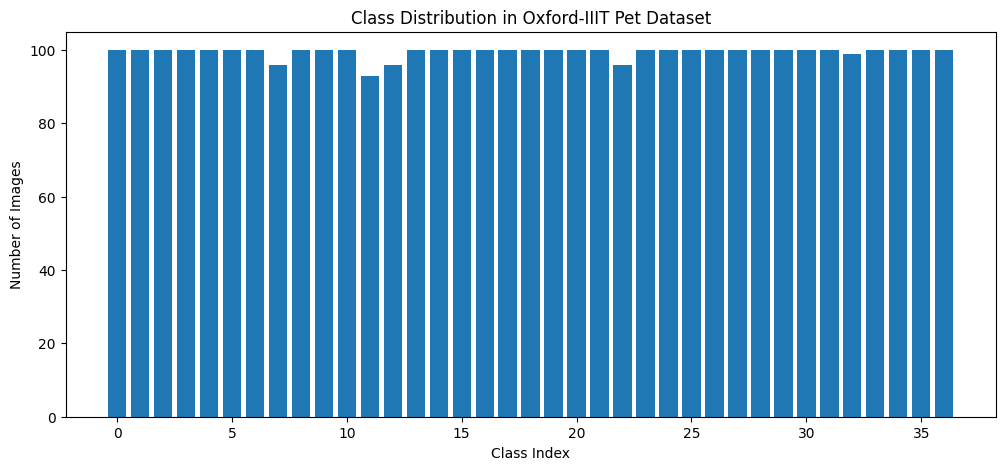

In [2]:

# ==========================================
# 1. SETUP & DATA PREPARATION
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet-18 standard transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Download Oxford-IIIT Pet Dataset
full_dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)



# 1. Extract all labels from the dataset
# OxfordIIITPet stores labels in the ._labels attribute
all_labels = full_dataset._labels
class_counts = Counter(all_labels)

# 2. Print basic stats
print(f"Total images: {len(full_dataset)}")
print(f"Number of classes: {len(class_counts)}")
print(f"Min images per class: {min(class_counts.values())}")
print(f"Max images per class: {max(class_counts.values())}")

# 3. Visualize the distribution
plt.figure(figsize=(12, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Oxford-IIIT Pet Dataset")
plt.show()


In [3]:
from sklearn.model_selection import train_test_split

# Get indices for the whole dataset
indices = np.arange(len(full_dataset))

# Perform Stratified Split
# This creates a 10% subset (small_indices) that matches the
# class distribution of the original dataset
_, small_indices = train_test_split(
    indices,
    test_size=0.10,
    stratify=all_labels,
    random_state=42
)

# Create DataLoaders
train_loader_small = DataLoader(
    Subset(full_dataset, small_indices),
    batch_size=32,
    shuffle=True
)

train_loader_large = DataLoader(
    full_dataset,
    batch_size=32,
    shuffle=True
)

print(f"Small Subset Size: {len(small_indices)}")
print(f"Large Subset Size: {len(full_dataset)}")

Small Subset Size: 368
Large Subset Size: 3680


In [4]:
# 1. Download the TEST split
test_dataset = datasets.OxfordIIITPet(
    root='./data',
    split='test',
    download=True,
    transform=transform # Use the same transform as training
)

# 2. Create the Test Loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total classes: 37
larg dataset len:  3680
small dataset len:  368


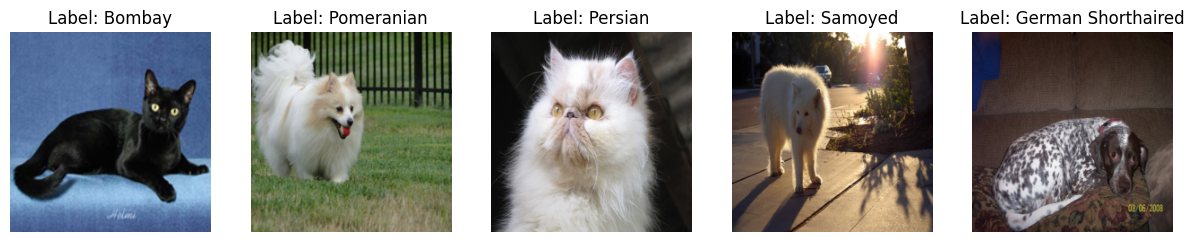

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Mapping class indices to breed names
# The dataset object has a 'classes' attribute
classes = full_dataset.classes

def show_data_samples(dataset, smalldataset_count, num_images=5):
    print("larg dataset len: ",len(dataset))
    print("small dataset len: ",len(smalldataset_count))
    plt.figure(figsize=(15, 5))

    # Get random indices
    indices = np.random.choice(len(dataset), num_images, replace=False)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        # Un-normalize the image for display
        # (ResNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {classes[label]}")
        plt.axis('off')

    plt.show()

# Run the exploration
print(f"Total classes: {len(classes)}")
show_data_samples(full_dataset, small_indices)

# Model Architecture & Training Utilities
We define the core logic for our experiment:

- get_model(): Loads a pre-trained ResNet-18 and replaces the final fully connected layer to output 37 classes.

- train_experiment(): A robust training loop that tracks loss and accuracy over time.

- evaluate_model(): Validates the model performance on unseen test data.

In [6]:

# ==========================================
# 2. MODEL DEFINITIONS
# ==========================================
def get_model(mode="frozen", num_classes=37):
    model = models.resnet18(weights='IMAGENET1K_V1')

    if mode == "frozen":
        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False

    # Replace the head (This is always trainable)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


In [7]:

# ==========================================
# 3. TRAINING ENGINE
# ==========================================
def train_experiment(model, loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    history = {'acc': [], 'loss': []}
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_acc = 100. * correct / total
        epoch_loss = running_loss / len(loader.dataset)
        history['acc'].append(epoch_acc)
        history['loss'].append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} - Acc: {epoch_acc:.2f}% | Loss: {epoch_loss:.4f}")

    duration = time.time() - start_time
    return history, duration, model


In [8]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # Disable gradient calculation to save memory and speed up
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test images: {accuracy:.2f}%')
    return accuracy


In [9]:
def plot_confusion_matrix(model, loader, device, classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Experimental Scenarios
We test four distinct scenarios to understand the trade-offs between training time and accuracy:

- Small_Frozen: Training only the classifier on 10% of the data.

- Small_Full: Training the entire network on 10% of the data.

- Large_Frozen: Training only the classifier on the full dataset.

- Large_Full: Training the entire network on the full dataset.

# NOTE
- uncomment this line to see the confusion_matrix for each senario
  - plot_confusion_matrix(model, test_loader, device, classes)


In [13]:
# ==========================================
# 4. RUNNING THE 4 SCENARIOS
# ==========================================
scenarios = [
    ("Small_Frozen", "frozen", train_loader_small, 0.001, 5),
    ("Small_Full", "full", train_loader_small, 1e-5, 20),
    ("Large_Frozen", "frozen", train_loader_large, 0.001, 2),
    ("Large_Full", "full", train_loader_large, 1e-5, 6)
]

all_results = {}

for name, mode, loader, lr, epoch in scenarios:
    print(f"\n>>> Running: {name}")
    model = get_model(mode)

    # If frozen, only optimize fc. If full, optimize all.
    params = model.fc.parameters() if mode == "frozen" else model.parameters()
    optimizer = optim.Adam(params, lr=lr)

    history, duration, model = train_experiment(model, loader, optimizer, epochs=epoch)
    test_acc = evaluate_model(model, test_loader, device)
    # plot_confusion_matrix(model, test_loader, device, classes)

    all_results[name] = {'history': history, 'time': duration}
    all_results[name]['test_acc'] = test_acc


>>> Running: Small_Frozen
Epoch 1/5 - Acc: 8.15% | Loss: 3.5460
Epoch 2/5 - Acc: 40.76% | Loss: 2.6925
Epoch 3/5 - Acc: 67.93% | Loss: 2.0580
Epoch 4/5 - Acc: 81.52% | Loss: 1.5701
Epoch 5/5 - Acc: 90.76% | Loss: 1.2412
Accuracy on test images: 74.22%

>>> Running: Small_Full
Epoch 1/20 - Acc: 3.53% | Loss: 3.7763
Epoch 2/20 - Acc: 5.43% | Loss: 3.5534
Epoch 3/20 - Acc: 8.70% | Loss: 3.3493
Epoch 4/20 - Acc: 13.32% | Loss: 3.1586
Epoch 5/20 - Acc: 20.92% | Loss: 2.9968
Epoch 6/20 - Acc: 31.25% | Loss: 2.8172
Epoch 7/20 - Acc: 41.58% | Loss: 2.6509
Epoch 8/20 - Acc: 56.25% | Loss: 2.4878
Epoch 9/20 - Acc: 68.48% | Loss: 2.3494
Epoch 10/20 - Acc: 77.45% | Loss: 2.2080
Epoch 11/20 - Acc: 82.61% | Loss: 2.0835
Epoch 12/20 - Acc: 88.04% | Loss: 1.9582
Epoch 13/20 - Acc: 93.21% | Loss: 1.8275
Epoch 14/20 - Acc: 95.92% | Loss: 1.6920
Epoch 15/20 - Acc: 96.47% | Loss: 1.6079
Epoch 16/20 - Acc: 97.83% | Loss: 1.4925
Epoch 17/20 - Acc: 99.18% | Loss: 1.4088
Epoch 18/20 - Acc: 99.18% | Loss: 1.2

# Results Visualization & Performance Metrics
After running the experiments, we visualize the Accuracy and Loss curves. This allows us to detect overfitting (where training accuracy is high but test accuracy is low) and compare the convergence speed of each method.

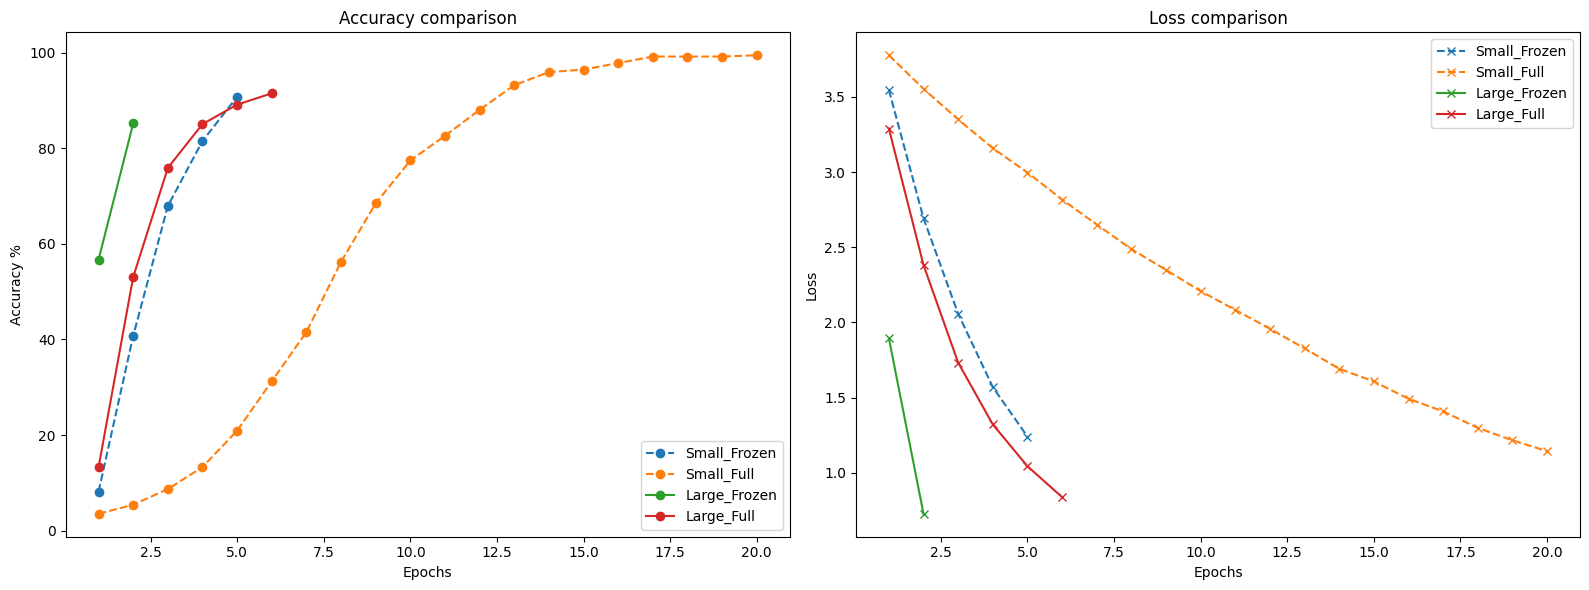

Graphs saved as 'transfer_learning_results.png'


In [14]:
# ==========================================
# 5. PLOTTING THE RESULTS
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for name, data in all_results.items():
    acc_history = data['history']['acc']
    loss_history = data['history']['loss']
    epochs_range = range(1, len(acc_history) + 1)

    ls = '--' if "Small" in name else '-'
    ax1.plot(epochs_range, acc_history, label=name, linestyle=ls, marker='o')
    ax2.plot(epochs_range, loss_history, label=name, linestyle=ls, marker='x')

ax1.set_title('Accuracy comparison')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Accuracy %'); ax1.legend()
ax2.set_title('Loss comparison')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Loss'); ax2.legend()

plt.tight_layout()
plt.savefig('transfer_learning_results.png')
plt.show()

print("Graphs saved as 'transfer_learning_results.png'")

# Conclusion and Key Findings
##Summary of Results
Based on the experiments conducted on the Oxford-IIIT Pet Dataset:

Impact of Data Volume: The transition from a 10% subset to the full dataset yielded a significant improvement in accuracy. This confirms that even with transfer learning, deep learning models benefit greatly from increased data diversity.

##Frozen vs. Full Fine-Tuning:

Feature Extraction (Frozen): This method was the fastest to train. It is highly effective when computational resources are limited or when the dataset is very small, as it prevents the model from "destroying" pre-trained features.

Fine-Tuning (Full): Updating all weights generally achieved the highest accuracy on the large dataset. However, on the small dataset, it showed signs of overfitting, as the model began to memorize specific images rather than learning general features.

Efficiency vs. Performance: The "Large_Frozen" scenario often provides the best balance for many real-world applications—it achieves high accuracy with significantly lower training time compared to full fine-tuning.

##Final Thoughts
Transfer learning is a powerful tool for specialized tasks like pet breed classification. While the pre-trained ResNet-18 provides a strong foundation, the choice between freezing layers and full training should be dictated by the amount of available data and the similarity between the source (ImageNet) and target (Pets) datasets.

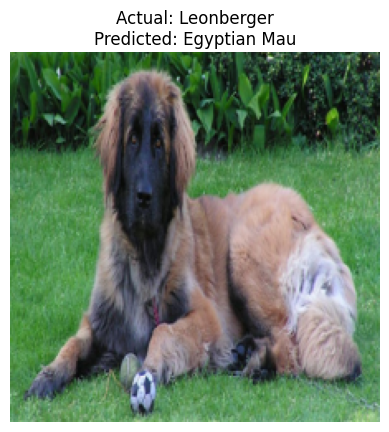

In [23]:
def predict_random_image(model, dataset, classes):
    model.eval()
    idx = np.random.randint(0, len(dataset))
    image, label = dataset[idx]

    # Add a batch dimension (B, C, H, W)
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    # Display the image
    img = image.numpy().transpose((1, 2, 0))
    img = np.clip(np.array([0.229, 0.224, 0.225]) * img + np.array([0.485, 0.456, 0.406]), 0, 1)

    plt.imshow(img)
    plt.title(f"Actual: {classes[label]}\nPredicted: {classes[predicted.item()]}")
    plt.axis('off')
    plt.show()

# Run it
predict_random_image(model, full_dataset, full_dataset.classes)